In [1]:
#pip install pandas numpy nltk wordcloud textblob scikit-learn matplotlib seaborn imbalanced-learn
import gzip
import json

import pandas as pd 
import numpy as np 

import nltk
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn import preprocessing 
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

/Users/yuvi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yuvi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
def parse(path):
    """
    Generator function that reads a gzip compressed file containing JSON entries.
    
    Args:
    path (str): The file path to the gzip-compressed file.

    Yields:
    dict: Each line in the file is a JSON object, converted to a Python dictionary.
    """
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    """
    Constructs a pandas DataFrame from a gzip compressed file containing JSON objects on each line.
    
    Args:
    path (str): The file path to the gzip-compressed file.

    Returns:
    DataFrame: A pandas DataFrame where each row corresponds to one JSON object.
    """
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
# Applying the getDF function to parse the dataset
df = getDF('Luxury_Beauty_5.json.gz')

In [4]:
# Displaying the dataset
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4.0,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,1504396800,NaN,NaN
34274,4.0,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,1504396800,NaN,NaN
34275,1.0,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,Did nothing,One Star,1503619200,NaN,NaN
34276,5.0,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,I love the Oribe bright blonde radiance spray....,No more brass!,1499472000,NaN,NaN


In [5]:
# Printing the shape and information of the dataset 
print ("The shape of the  data is:"+ str(df.shape))
df.info()

The shape of the  data is:(34278, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 34278 entries, 0 to 34277
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         34278 non-null  float64
 1   verified        34278 non-null  bool   
 2   reviewTime      34278 non-null  object 
 3   reviewerID      34278 non-null  object 
 4   asin            34278 non-null  object 
 5   style           16841 non-null  object 
 6   reviewerName    34278 non-null  object 
 7   reviewText      34265 non-null  object 
 8   summary         34263 non-null  object 
 9   unixReviewTime  34278 non-null  int64  
 10  vote            6532 non-null   object 
 11  image           617 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 3.2+ MB


In [6]:
# Creating a copy
data=df.copy()

# Checking for null values
data.isnull().sum()

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
style             17437
reviewerName          0
reviewText           13
summary              15
unixReviewTime        0
vote              27746
image             33661
dtype: int64

In [7]:
# Dropping the columns not needed 
data = data.drop(columns=[ 'style', 'image', 'verified', 'unixReviewTime', 'reviewerName'])
data

,overall,reviewTime,reviewerID,asin,reviewText,summary,vote
0,5.0,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,NaN
1,5.0,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,NaN
2,5.0,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,NaN
3,5.0,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,Thanks!!,Five Stars,NaN
4,5.0,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,NaN
...,...,...,...,...,...,...,...
34273,4.0,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,NaN
34274,4.0,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,NaN
34275,1.0,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,Did nothing,One Star,NaN
34276,5.0,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,I love the Oribe bright blonde radiance spray....,No more brass!,NaN


In [8]:
# Imputing the columns 
data['reviewText']=data['reviewText'].fillna('N/A')
data['summary']=data['summary'].fillna('N/A')
data['vote']=data['vote'].fillna(0)

In [9]:
# Checking for null values
data.isnull().sum()

overall       0
reviewTime    0
reviewerID    0
asin          0
reviewText    0
summary       0
vote          0
dtype: int64

In [10]:
# Checking the imputation for the vote column 
data['vote'].value_counts()

vote
0      27746
2       2337
3       1548
4        571
5        383
       ...  
231        1
85         1
82         1
67         1
371        1
Name: count, Length: 110, dtype: int64

In [11]:
# Splitting the date 
date = data["reviewTime"].str.split(" ", n = 1, expand = True) 
  
# Adding month 
data["month"]= date[0] 
  
# Adding day
data["date"]= date[1] 

data=data.drop(['reviewTime'], axis=1)
data.head()

,overall,reviewerID,asin,reviewText,summary,vote,month,date
0,5.0,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,0,01,"5, 2018"
1,5.0,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,0,04,"5, 2017"
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,0,03,"27, 2017"
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,Thanks!!,Five Stars,0,03,"20, 2017"
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,0,02,"28, 2017"


In [12]:
day = data["date"].str.split(",", n = 1, expand = True) 
  
# Adding day 
data["day"]= day[0] 
  
# Adding year  
data["year"]= day[1] 

data=data.drop(['date'], axis=1)
data.head()

,overall,reviewerID,asin,reviewText,summary,vote,month,day,year
0,5.0,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,0,01,5,2018
1,5.0,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,0,04,5,2017
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,0,03,27,2017
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,Thanks!!,Five Stars,0,03,20,2017
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,0,02,28,2017


In [13]:
def sentiment_review(row):  
    """
    Determines the sentiment of a review based on the 'overall' rating.

    Args:
    row (dict or pd.Series): A dictionary or a pandas Series object representing a single row of a DataFrame.

    Returns:
    str: The sentiment of the review ('Neutral', 'Negative', 'Positive') or -1 if the rating is outside the expected range.
    """
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [14]:
# Applying the function 
data['sentiment'] = data.apply(sentiment_review, axis=1)
data.head()

,overall,reviewerID,asin,reviewText,summary,vote,month,day,year,sentiment
0,5.0,A2HOI48JK8838M,B00004U9V2,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,0,01,5,2018,Positive
1,5.0,A1YIPEY7HX73S7,B00004U9V2,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,0,04,5,2017,Positive
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,0,03,27,2017,Positive
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,Thanks!!,Five Stars,0,03,20,2017,Positive
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,0,02,28,2017,Positive


In [15]:
# Concatenating the reviewText and summary for better analysis 
data['reviews']=data['reviewText']+data['summary']
data=data.drop(['reviewText', 'summary'], axis=1)
data.head()

,overall,reviewerID,asin,vote,month,day,year,sentiment,reviews
0,5.0,A2HOI48JK8838M,B00004U9V2,0,01,5,2018,Positive,This handcream has a beautiful fragrance. It d...
1,5.0,A1YIPEY7HX73S7,B00004U9V2,0,04,5,2017,Positive,"wonderful hand lotion, for seriously dry skin,..."
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,03,27,2017,Positive,"Best hand cream around. Silky, thick, soaks i..."
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,0,03,20,2017,Positive,Thanks!!Five Stars
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,02,28,2017,Positive,Great hand lotion. Soaks right in and leaves ...


In [16]:
def clean(text):
    """
    Cleans the input text by lowering the case and removing unwanted patterns and characters,
    tailored for sentiment analysis to retain punctuation that might convey sentiment.

    Args:
    text (str): The text to clean.

    Returns:
    str: The cleaned text.
    """
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    # Remove punctuation except for exclamation points and question marks
    retain_punctuation = '!?'
    pattern = '[%s]' % re.escape(string.punctuation.replace('!', '').replace('?', ''))
    text = re.sub(pattern, '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [17]:
# Applying the function 
data['reviews']=data['reviews'].apply(lambda x:clean(x))
data.head()

,overall,reviewerID,asin,vote,month,day,year,sentiment,reviews
0,5.0,A2HOI48JK8838M,B00004U9V2,0,01,5,2018,Positive,this handcream has a beautiful fragrance it do...
1,5.0,A1YIPEY7HX73S7,B00004U9V2,0,04,5,2017,Positive,wonderful hand lotion for seriously dry skin s...
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,03,27,2017,Positive,best hand cream around silky thick soaks in a...
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,0,03,20,2017,Positive,thanks!!five stars
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,02,28,2017,Positive,great hand lotion soaks right in and leaves s...


In [18]:
# Creating the list of stop words 
stop_words= ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", 
             "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
             "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
             "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
             "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
             "of", "at", "by", "for", "with", "about", "between", "into", "through", "during", "to", "from",
             "in", "out", "on", "again","further", "then", "once", "here", "there", "when", "where", "why", "how", "all",
             "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", 
             "too", "very", "can", "will", "just", "should", "now"]

In [19]:
# Applying the function
data['reviews'] = data['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
data.head()

,overall,reviewerID,asin,vote,month,day,year,sentiment,reviews
0,5.0,A2HOI48JK8838M,B00004U9V2,0,01,5,2018,Positive,handcream beautiful fragrance doesnt stay prot...
1,5.0,A1YIPEY7HX73S7,B00004U9V2,0,04,5,2017,Positive,wonderful hand lotion seriously dry skin stays...
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,03,27,2017,Positive,best hand cream around silky thick soaks way l...
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,0,03,20,2017,Positive,thanks!!five stars
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,02,28,2017,Positive,great hand lotion soaks right leaves skin supe...


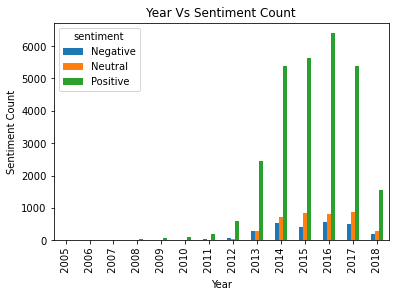

In [20]:
# Group the data by 'year' and 'sentiment' and count the occurrences
sentiment_counts = data.groupby(['year', 'sentiment']).size().unstack()

# Plotting the sentiment counts by year
sentiment_counts.plot(kind='bar', legend=True) 
plt.title('Year Vs Sentiment Count')
plt.xlabel('Year')
plt.ylabel('Sentiment Count')
plt.show()

In [21]:
# Adding the polarity column 
data['polarity'] = data['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
data['len'] = data['reviews'].astype(str).apply(len)
data['count_words'] = data['reviews'].apply(lambda x: len(str(x).split()))
data.head()

,overall,reviewerID,asin,vote,month,day,year,sentiment,reviews,polarity,len,count_words
0,5.0,A2HOI48JK8838M,B00004U9V2,0,01,5,2018,Positive,handcream beautiful fragrance doesnt stay prot...,0.850000,99,12
1,5.0,A1YIPEY7HX73S7,B00004U9V2,0,04,5,2017,Positive,wonderful hand lotion seriously dry skin stays...,0.271250,173,27
2,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,03,27,2017,Positive,best hand cream around silky thick soaks way l...,0.344444,91,15
3,5.0,A2R4UNHFJBA6PY,B00004U9V2,0,03,20,2017,Positive,thanks!!five stars,0.000000,18,2
4,5.0,A2QCGHIJ2TCLVP,B00004U9V2,0,02,28,2017,Positive,great hand lotion soaks right leaves skin supe...,0.503810,101,16


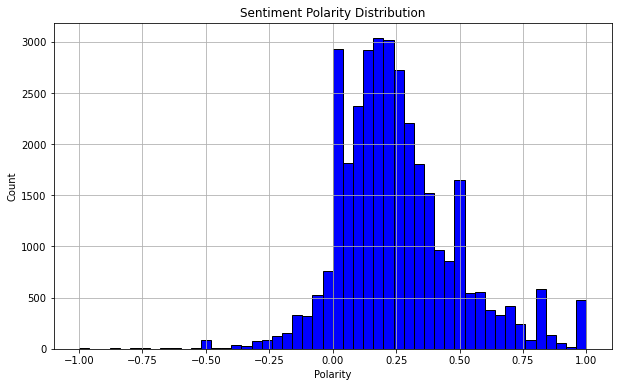

In [22]:
# Plotting the histogram for sentiment polarity
plt.figure(figsize=(10, 6))
plt.hist(data['polarity'], bins=50, color='blue', edgecolor='black')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.grid(True) 
plt.show()

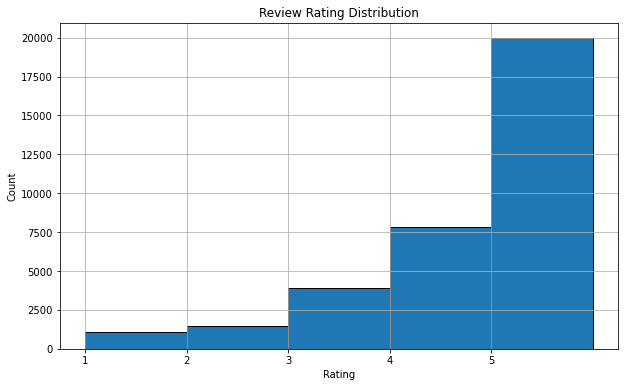

In [23]:
# Plotting the histogram for review ratings
plt.figure(figsize=(10, 6))
plt.hist(data['overall'], bins=range(int(data['overall'].min()), int(data['overall'].max()) + 2), edgecolor='black')
plt.title('Review Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(int(data['overall'].min()), int(data['overall'].max()) + 1)) 
plt.grid(True)  
plt.show()

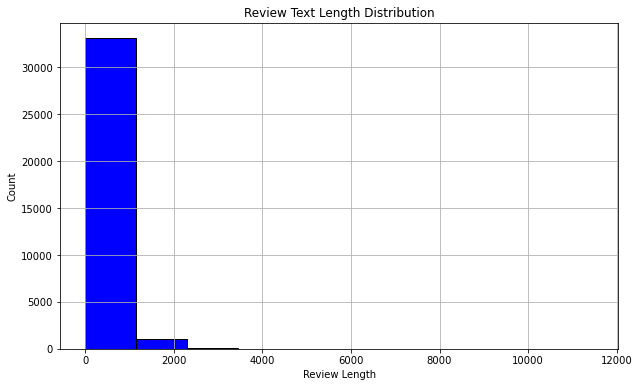

In [24]:
# Plotting the histogram for review text lengths
plt.figure(figsize=(10, 6))
plt.hist(data['len'], bins=10, color='blue', edgecolor='black')  
plt.title('Review Text Length Distribution')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.grid(True) 
plt.show()

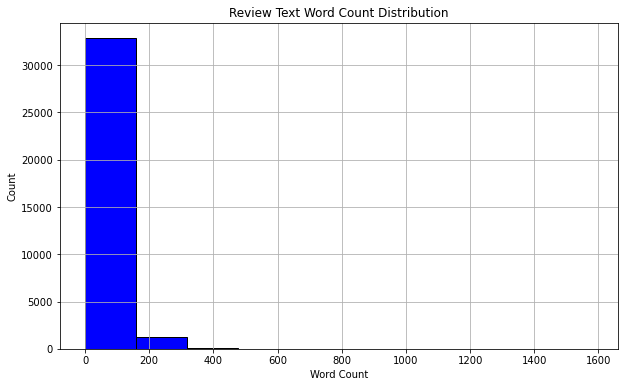

In [25]:
# Plotting the histogram for review text word counts
plt.figure(figsize=(10, 6))
plt.hist(data['count_words'], bins=10, color='blue', edgecolor='black')  
plt.title('Review Text Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.grid(True)  
plt.show()

In [26]:
#Filtering data
review_pos = data[data["sentiment"]=='Positive'].dropna()
review_neu = data[data["sentiment"]=='Neutral'].dropna()
review_neg = data[data["sentiment"]=='Negative'].dropna()

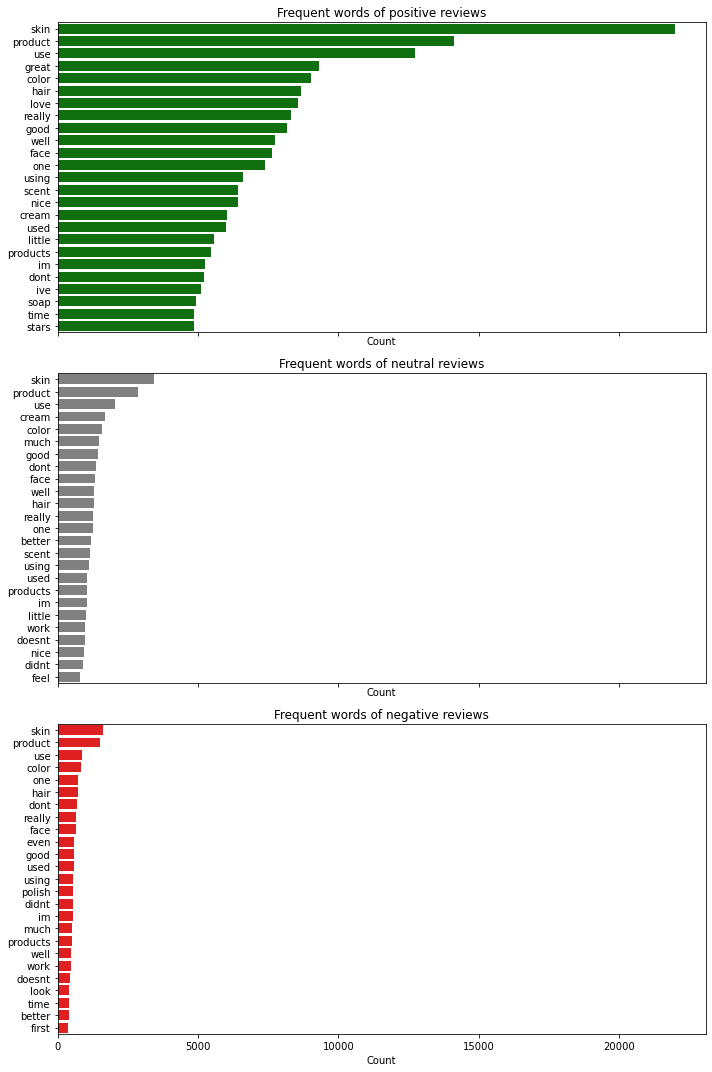

In [27]:
def generate_ngrams(text, n_gram=1):
    """Generate n-grams from text."""
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def plot_horizontal_bar_chart(df, color, ax, title):
    """Plot horizontal bar chart using seaborn."""
    sns.barplot(x="wordcount", y="word", data=df, ax=ax, color=color)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("")


fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Analyzing and plotting positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'green', axes[0], "Frequent words of positive reviews")

# Analyzing and plotting neutral reviews
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'grey', axes[1], "Frequent words of neutral reviews")

# Analyzing and plotting negative reviews
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'red', axes[2], "Frequent words of negative reviews")

plt.tight_layout()
plt.show()

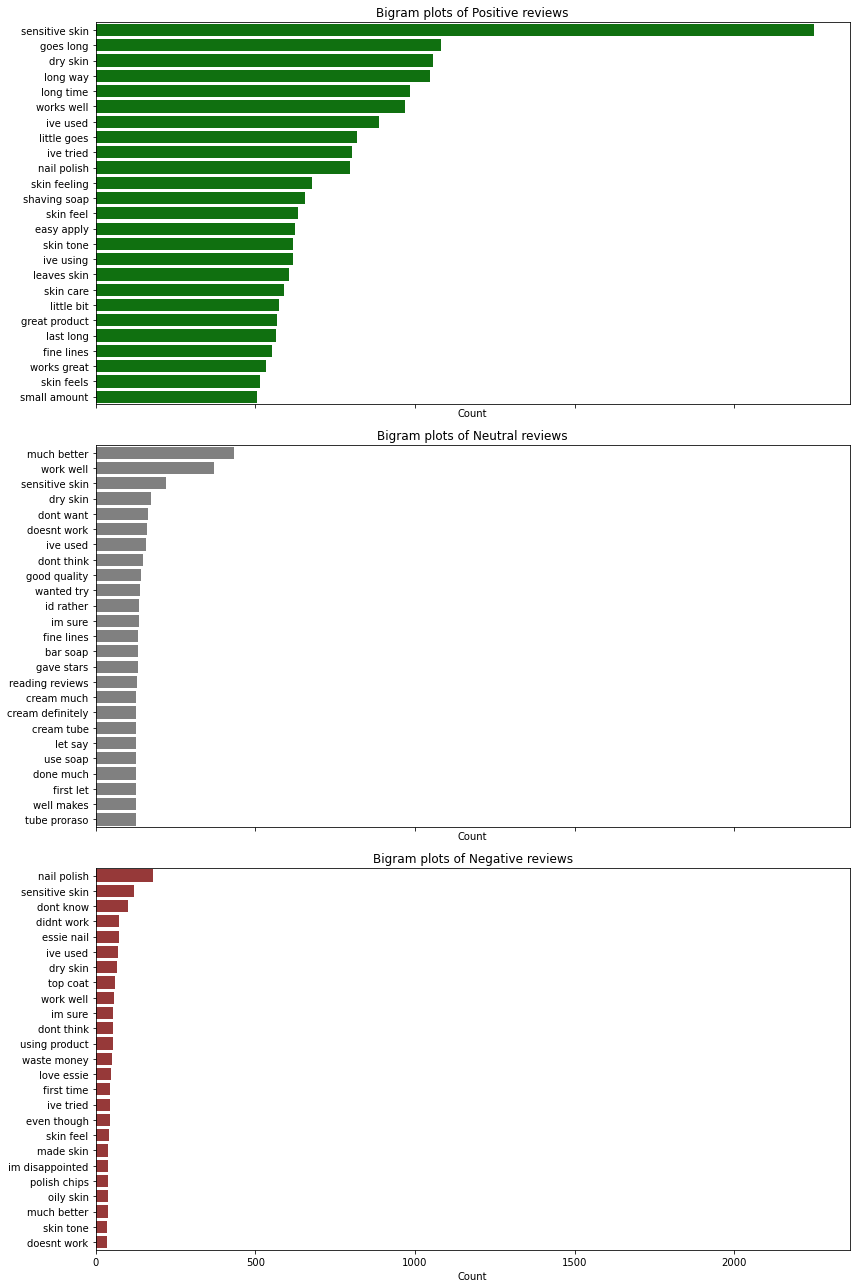

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Analyzing and plotting bigrams for positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'green', axes[0], "Bigram plots of Positive reviews")

# Analyzing and plotting bigrams for neutral reviews
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'grey', axes[1], "Bigram plots of Neutral reviews")

# Analyzing and plotting bigrams for negative reviews
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'brown', axes[2], "Bigram plots of Negative reviews")

plt.tight_layout()
plt.show()

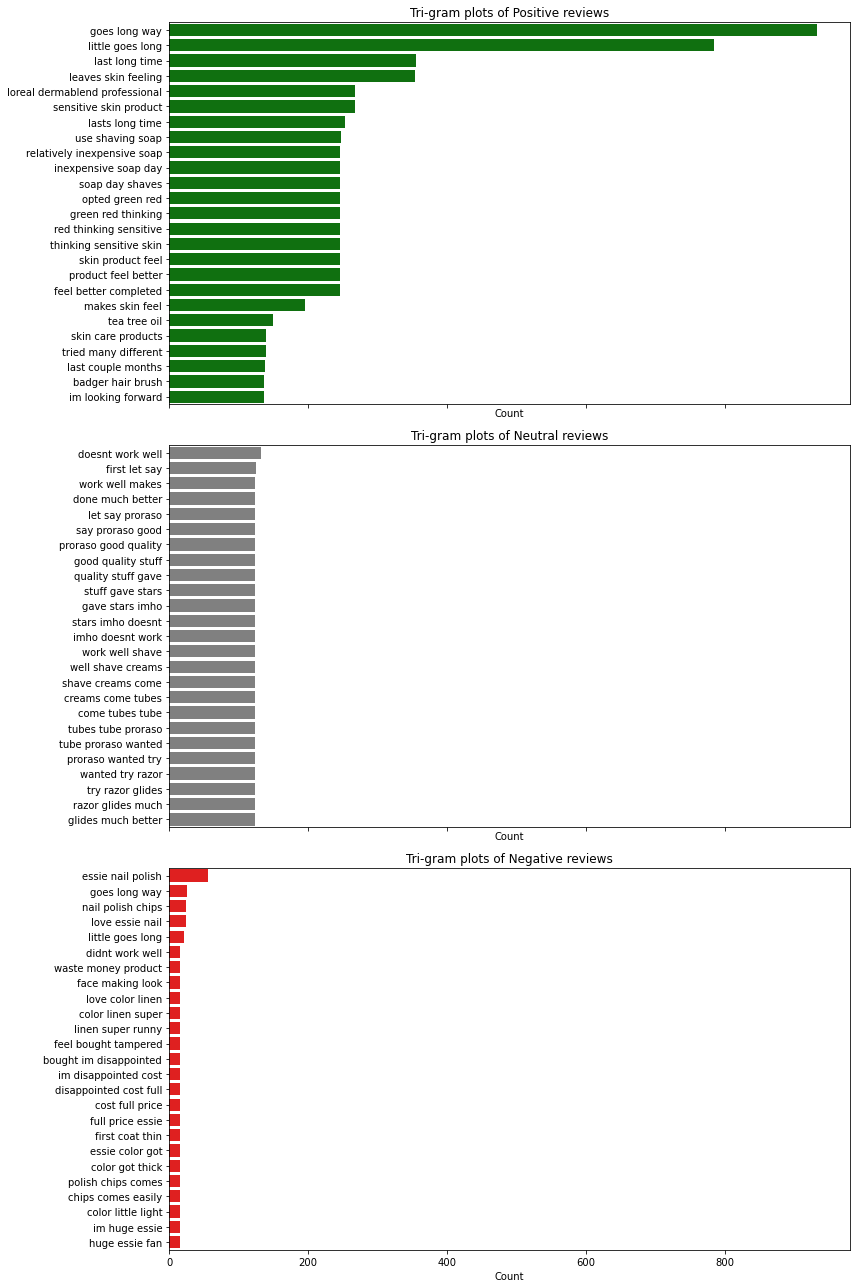

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Analyzing and plotting trigrams for positive reviews
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'green', axes[0], "Tri-gram plots of Positive reviews")

# Resetting the frequency dictionary for neutral reviews
freq_dict.clear()
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'grey', axes[1], "Tri-gram plots of Neutral reviews")

# Resetting the frequency dictionary for negative reviews
freq_dict.clear()
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
fd_sorted.columns = ["word", "wordcount"]
plot_horizontal_bar_chart(fd_sorted.head(25), 'red', axes[2], "Tri-gram plots of Negative reviews")

plt.tight_layout()
plt.show()

In [30]:
# Calling the label encoder and applying it to sentiments
label_encoder = preprocessing.LabelEncoder() 
data['sentiment']= label_encoder.fit_transform(data['sentiment']) 
data['sentiment'].unique()

array([2, 1, 0])

In [31]:
data['sentiment'].value_counts()

sentiment
2    27803
1     3884
0     2591
Name: count, dtype: int64

In [32]:
# Extracting 'reviews' for processing
review_features=data.copy()
review_features=data[['reviews']].reset_index(drop=True)
review_features.head()

,reviews
0,handcream beautiful fragrance doesnt stay prot...
1,wonderful hand lotion seriously dry skin stays...
2,best hand cream around silky thick soaks way l...
3,thanks!!five stars
4,great hand lotion soaks right leaves skin supe...


In [33]:
# Performing lemmatization on the review dataframe
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review) 

In [34]:
# Performing TF-IDF on the features
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [35]:
# Extracting the response
y=data['sentiment']

In [36]:
# Performing sampling technique
print(f'Original dataset shape : {Counter(y)}')
smote = BorderlineSMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 27803, 1: 3884, 0: 2591})
Resampled dataset shape Counter({2: 27803, 1: 27803, 0: 27803})


In [37]:
# Divide the dataset into Train and Test sets 
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

In [38]:
# Train decision tree with information gain
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)

# Predict and evaluate
y_train_pred_entropy = clf_entropy.predict(X_train)
y_test_pred_entropy = clf_entropy.predict(X_test)

metrics = {
    'Training Error': 1 - accuracy_score(y_train, y_train_pred_entropy),
    'Testing Error': 1 - accuracy_score(y_test, y_test_pred_entropy),
    'Training Accuracy': accuracy_score(y_train, y_train_pred_entropy),
    'Testing Accuracy': accuracy_score(y_test, y_test_pred_entropy),
    '' : classification_report(y_test, y_test_pred_entropy)
}

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Training Error: 0.03745110674839269
Testing Error: 0.11917036326579544
Training Accuracy: 0.9625488932516073
Testing Accuracy: 0.8808296367342046
:               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5638
           1       0.90      0.88      0.89      5527
           2       0.93      0.80      0.86      5517

    accuracy                           0.88     16682
   macro avg       0.89      0.88      0.88     16682
weighted avg       0.89      0.88      0.88     16682



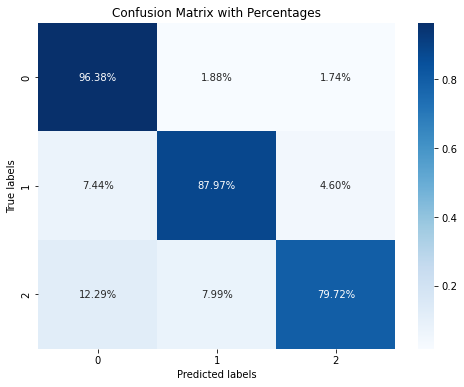

In [39]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_entropy)

# Convert the confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=True, yticklabels=True)
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

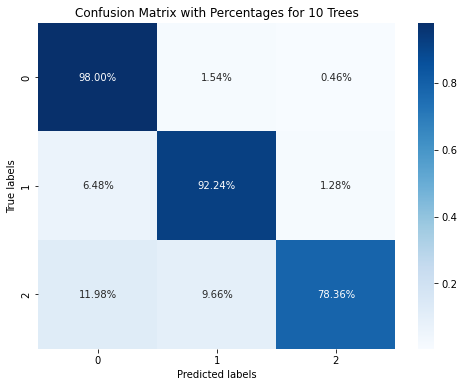

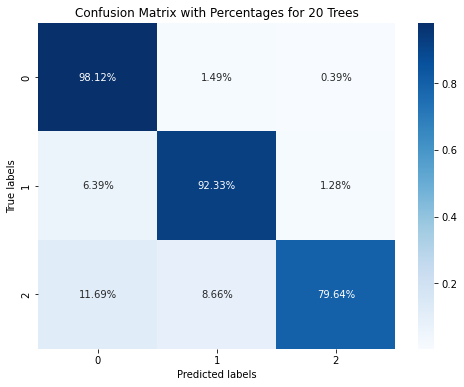

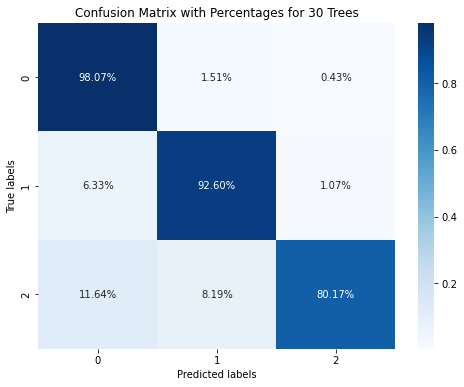

Results for 10 Trees:
Training Error: 0.04007373327138941
Testing Error: 0.10406426087999043
Training Accuracy: 0.9599262667286106
Testing Accuracy: 0.8959357391200096
Classification Report:               precision    recall  f1-score   support

           0       0.84      0.98      0.91      5638
           1       0.89      0.92      0.91      5527
           2       0.98      0.78      0.87      5517

    accuracy                           0.90     16682
   macro avg       0.90      0.90      0.89     16682
weighted avg       0.90      0.90      0.89     16682

--------------------------------------------------
Results for 20 Trees:
Training Error: 0.038035577802089104
Testing Error: 0.09908883826879267
Training Accuracy: 0.9619644221979109
Testing Accuracy: 0.9009111617312073
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.98      0.91      5638
           1       0.90      0.92      0.91      5527
           2       0.9

In [40]:
# Number of trees to explore
n_estimators_list = [10, 20, 30]

# Initialize a dictionary to store metrics
results = {n: {} for n in n_estimators_list}

# Loop through each number of trees
for n_estimators in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictions
    y_train_pred_rf = rf.predict(X_train)
    y_test_pred_rf = rf.predict(X_test)
    
    # Metrics
    results[n_estimators]['Training Error'] = 1 - accuracy_score(y_train, y_train_pred_rf)
    results[n_estimators]['Testing Error'] = 1 - accuracy_score(y_test, y_test_pred_rf)
    results[n_estimators]['Training Accuracy'] = accuracy_score(y_train, y_train_pred_rf)
    results[n_estimators]['Testing Accuracy'] = accuracy_score(y_test, y_test_pred_rf)
    results[n_estimators]['Classification Report'] = classification_report(y_test, y_test_pred_rf)
    
    # Calculate the confusion matrix and convert to percentages
    cm = confusion_matrix(y_test, y_test_pred_rf)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
    plt.title(f'Confusion Matrix with Percentages for {n_estimators} Trees')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

# Print results
for n_estimators, metrics in results.items():
    print(f"Results for {n_estimators} Trees:")
    for metric_name, metric_value in metrics.items(): 
            print(f"{metric_name}: {metric_value}")
    print("-" * 50)

In [41]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_train_pred_entropy_new = model.predict(X_train)
y_test_pred_entropy_new = model.predict(X_test)

metrics = {
    'Training Error': 1 - accuracy_score(y_train, y_train_pred_entropy_new),
    'Testing Error': 1 - accuracy_score(y_test, y_test_pred_entropy_new),
    'Training Accuracy': accuracy_score(y_train, y_train_pred_entropy_new),
    'Testing Accuracy': accuracy_score(y_test, y_test_pred_entropy_new),
    '' : classification_report(y_test, y_test_pred_entropy_new)
}

for metric, value in metrics.items():
    print(f"{metric}: {value}")

Training Error: 0.15458510048406193
Testing Error: 0.18427047116652684
Training Accuracy: 0.8454148995159381
Testing Accuracy: 0.8157295288334732
:               precision    recall  f1-score   support

           0       0.76      0.93      0.83      5638
           1       0.81      0.75      0.78      5527
           2       0.91      0.76      0.83      5517

    accuracy                           0.82     16682
   macro avg       0.83      0.81      0.81     16682
weighted avg       0.83      0.82      0.81     16682



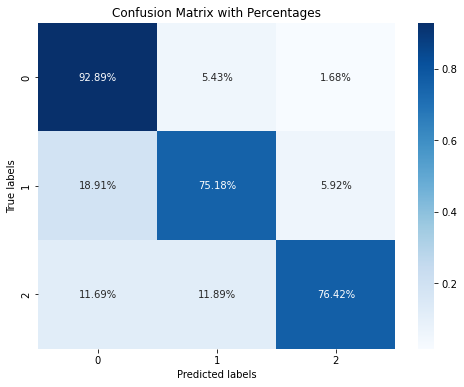

In [42]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred_entropy_new)

# Convert the confusion matrix to percentage
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues')
plt.title('Confusion Matrix with Percentages')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

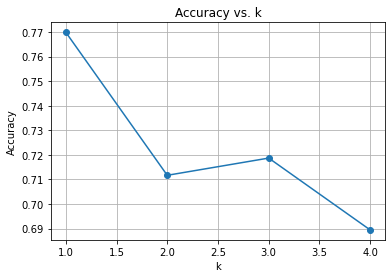

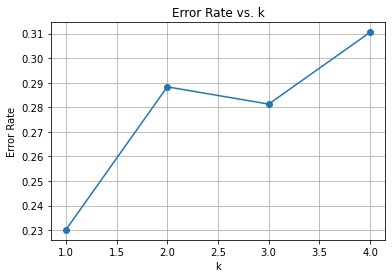

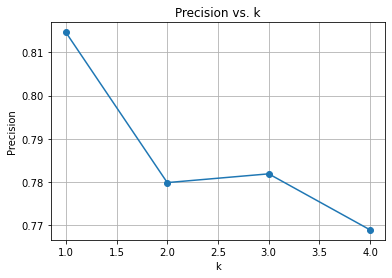

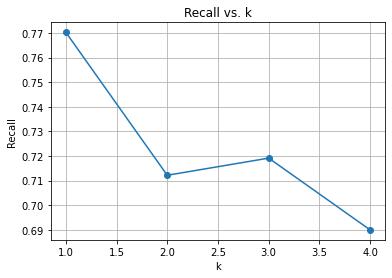

Optimal k: 1


In [43]:
k_values = list(range(1, 5))

accuracy_scores = []
error_rates = []
precision_scores = []
recall_scores = []

# Perform cross-validation for each k value
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, X_train, y_train, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])
    
    accuracy = np.mean(cv_results['test_accuracy'])
    error = 1 - accuracy
    precision = np.mean(cv_results['test_precision_macro'])
    recall = np.mean(cv_results['test_recall_macro'])
    
    accuracy_scores.append(accuracy)
    error_rates.append(error)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Plot accuracy vs. k
plt.plot(k_values, accuracy_scores, marker='o')
plt.title('Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Plot error rate vs. k
plt.plot(k_values, error_rates, marker='o')
plt.title('Error Rate vs. k')
plt.xlabel('k')
plt.ylabel('Error Rate')
plt.grid(True)
plt.show()

# Plot precision vs. k
plt.plot(k_values, precision_scores, marker='o')
plt.title('Precision vs. k')
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# Plot recall vs. k
plt.plot(k_values, recall_scores, marker='o')
plt.title('Recall vs. k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

optimal_k = k_values[error_rates.index(min(error_rates))]
print("Optimal k:", optimal_k)